In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=36d9801cda84b60df3aa027b4c2b14edf0f695ea6fdca6c1694a41cb533f13b7
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance as yf
import numpy as np

In [3]:
df = yf.download('BTC-USD',start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df['returns'] = np.log(df.Close.pct_change() + 1)

In [5]:
df['direction'] = [1 if i > 0 else -1 for i in df.returns]

In [10]:
def lagit(df, lags):
  names = []
  for i in range(1,lags + 1):
    df['Lag_'+str(i)] = df['returns'].shift(i)
    df['Lag_'+str(i)+'_dir'] = [1 if j > 0 else -1 for j in df['Lag_'+str(i)]]
    names.append('Lag_'+str(i)+'_dir')
    return names

In [13]:
dirnames = lagit(df,2)

In [15]:
df.dropna(inplace=True)

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model = LogisticRegression()

In [19]:
model.fit(df[dirnames], df['direction'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
df['prediction_Logit'] = model.predict(df[dirnames])

In [22]:
df['strat_Logit'] = df['prediction_Logit'] * df['returns']

In [23]:
np.exp(df[['returns', 'strat_Logit']].sum())

returns        8.921797
strat_Logit    6.972835
dtype: float64

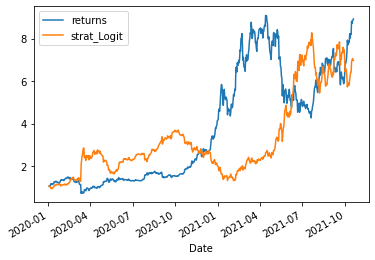

In [27]:
np.exp(df[['returns', 'strat_Logit']].cumsum()).plot()

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train, test = train_test_split(df, shuffle=False, test_size=0.25, random_state=0)

In [30]:
train = train.copy()

In [31]:
test = test.copy()

In [32]:
model = LogisticRegression()

In [33]:
model.fit(train[dirnames], train['direction'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
test['predictions_Logit'] = model.predict(test[dirnames])

In [36]:
test['strat_Logit'] = test['prediction_Logit'] * test['returns']

In [37]:
np.exp(test[['returns', 'strat_Logit']].sum())

returns        1.070247
strat_Logit    2.108220
dtype: float64

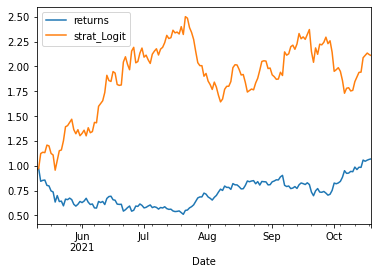

In [38]:
np.exp(test[['returns', 'strat_Logit']].cumsum()).plot()

In [39]:
from sklearn import metrics

In [40]:
metrics.confusion_matrix(test['direction'], test['prediction_Logit'])

array([[45, 31],
       [41, 46]])

In [42]:
metrics.classification_report(test['direction'], test['prediction_Logit'])

'              precision    recall  f1-score   support\n\n          -1       0.52      0.59      0.56        76\n           1       0.60      0.53      0.56        87\n\n    accuracy                           0.56       163\n   macro avg       0.56      0.56      0.56       163\nweighted avg       0.56      0.56      0.56       163\n'

In [43]:
print(metrics.classification_report(test['direction'], test['prediction_Logit']))

              precision    recall  f1-score   support

          -1       0.52      0.59      0.56        76
           1       0.60      0.53      0.56        87

    accuracy                           0.56       163
   macro avg       0.56      0.56      0.56       163
weighted avg       0.56      0.56      0.56       163

